In [12]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import tqdm
# from dgl import DGLGraph
import json
import pickle
import os
import spacy

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data preparation

In [13]:
# !pip install dgl==0.9.1
!pip install dgl
!pip install pandas


  Obtaining dependency information for dgl from https://files.pythonhosted.org/packages/e9/b0/daf76d5d813c6a7147850adb1a6b88244eba7986a56a09b4f3ff873516f5/dgl-1.1.3-cp310-cp310-manylinux1_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 61.6 MB/s eta 0:00:0000:0100:01


In [15]:
class ccf_ai(object):
    def __init__(self, dir):
        super(ccf_ai, self).__init__()
        self.dir = dir
        db_raw = open(self.dir + 'AI_collection.txt').readlines()
        nlp = spacy.load('en_core_web_lg')
        self.vec_paper = np.zeros((len(db_raw), 300))
        
        self.paper_w = np.zeros(len(db_raw))
        # ccf_set = np.zeros(len(db_raw), dtype=int)
        self.papers = []
        self.paper_ids_map = {}
        self.authors = []
        self.author_ids_map = {}
        ######### pd


        trange = tqdm.tqdm(range(len(db_raw)))
        for i in trange: # tqdm range
            sum_w = 0.
            d = json.loads(db_raw[i]) # one data sample

            paper_id = ''
            paper_title = ''
            paper_year = 0
            paper_venue = ''
            fos_pair = []

            if 'fos' in d:
                fos = d['fos']
                for f in fos:
                    fos_pair.append((f['name'], f['w'])) 
                    self.vec_paper[i, :] = self.vec_paper[i, :] + \
                                          nlp(f['name']).vector * f['w']
                    sum_w += f['w']
                self.vec_paper[i, :] = self.vec_paper[i, :] / sum_w
                self.paper_w[i] = sum_w # paper weight??

            if 'venue' in d:
                paper_venue = d['venue']['raw']

            if 'year' in d:
                paper_year = d['year']

            if 'id' in d:
                paper_id = d['id']
                if paper_id not in self.paper_ids_map:
                    self.paper_ids_map[paper_id] = len(self.papers) # map paper id to dataset id

            if 'title' in d:
                paper_title = d['title']

            self.papers.append({
                'gid': i,
                'id': paper_id,
                'title': paper_title,
                'year': paper_year,
                'venue': paper_venue,
                'fos': fos_pair
            })

            if 'authors' in d:
                da = d['authors']
                for j in da:
                    if j['id'] not in self.author_ids_map:
                        self.authors.append({
                            'gid': len(self.author_ids_map) + len(db_raw),
                            'id': j['id'],
                            'name': j['name']
                        })
                        self.author_ids_map[j['id']] = len(self.authors) - 1

        self.papers = pd.DataFrame(self.papers).set_index('gid').astype({'year': 'category','venue': 'category'})
        self.authors = pd.DataFrame(self.authors).set_index('gid').astype('category')

        self.edge_list = []
        self.edge_wt = []
        self.edge_ref = []
        self.author_write = [[] for i in range(len(self.author_ids_map))]
        self.author_ref = [[] for i in range(len(self.author_ids_map))]
        self.author_w_link = [[] for i in range(len(self.author_ids_map))] # set of all edge for an author in author_paper graph
        self.author_r_link = [[] for i in range(len(self.author_ids_map))] # set of all edge for an author in author_author graph

        self.paper_ref_paper = [[] for i in range(len(self.paper_ids_map))]  # idx of paper
        self.paper_author = [[] for i in range(len(self.paper_ids_map))]
        self.paper_link = [[] for i in range(len(self.paper_ids_map))]

        cnt = 0
        for i in tqdm.tqdm(range(len(db_raw))):
            d = json.loads(db_raw[i])
            ref = []
            if 'references' in d:
                ref = d['references']
            auth = []
            if 'authors' in d:
                auth = d['authors']
            for j in auth:
                if i not in self.author_write[self.author_ids_map[j['id']]]:
                    self.author_write[self.author_ids_map[j['id']]].append(i)

                self.paper_author[i].append(self.author_ids_map[j['id']])
                for k in ref:
                    if k in self.paper_ids_map:
                        if self.paper_ids_map[k] not in self.author_ref[self.author_ids_map[j['id']]]:
                            self.author_ref[self.author_ids_map[j['id']]].append(self.paper_ids_map[k])
                        self.paper_ref_paper[i].append(self.paper_ids_map[k])

        for i in range(len(self.author_ids_map)):
            for j in range(len(self.author_write[i])):
                tmp_write = self.author_write[i][j]
                self.author_w_link[i].append(cnt)
                self.paper_link[tmp_write].append(cnt)
                self.edge_wt.append((i + len(self.paper_ids_map), tmp_write, cnt))
                cnt += 1

        for i in range(len(self.author_ids_map)):
            for j in range(len(self.author_ref[i])):
                tmp_ref = self.author_ref[i][j]
                if tmp_ref not in self.author_write[i]:
                    self.author_r_link[i].append(cnt)
                    self.paper_link[tmp_ref].append(cnt)
                    self.edge_ref.append((i + len(self.paper_ids_map), tmp_ref, cnt))
                    cnt += 1

        print('Count: ', cnt)

        self.edge_list = self.edge_wt + self.edge_ref

        self.writes = pd.DataFrame(self.edge_wt, columns=['idx_A', 'idx_P', 'gid']).set_index('gid')
        self.writes['rt'] = True
        self.refs = pd.DataFrame(self.edge_ref, columns=['idx_A', 'idx_P', 'gid']).set_index('gid')
        self.refs['rt'] = False
        self.links = pd.concat([self.writes, self.refs], axis=0)
        


In [16]:
db = ccf_ai('/kaggle/input/data-p2r/')
db.papers

100%|██████████| 3590/3590 [00:00<00:00, 6880.61it/s]


Count:  106188


,id,title,year,venue,fos
gid,,,,,
0,1483870316,"You Only Look Once: Unified, Real-Time Object ...",2016,computer vision and pattern recognition,"[(Machine learning, 0.43618834), (Object-class..."
1,1537698211,Human Pose Estimation with Iterative Error Fee...,2016,computer vision and pattern recognition,"[(Computer vision, 0.4502649), (Machine learni..."
2,1552576688,Minimum error bounded efficient ℓ1 tracker wit...,2011,computer vision and pattern recognition,"[(Linear least squares, 0.476929843), (Mathema..."
3,1569892065,Efficient Piecewise Training of Deep Structure...,2016,computer vision and pattern recognition,"[(Image segmentation, 0.5859425), (Conditional..."
4,1573040851,Jointly Modeling Embedding and Translation to ...,2016,computer vision and pattern recognition,"[(Natural language, 0.496494561), (Semantics, ..."
...,...,...,...,...,...
3585,764651262,FlowNet: Learning Optical Flow with Convolutio...,2015,international conference on computer vision,"[(Supervised learning, 0.5532485), (Pattern re..."
3586,845365781,Holistically-Nested Edge Detection,2015,international conference on computer vision,"[(Feature (computer vision), 0.6397062), (Comp..."
3587,846669277,Differential Recurrent Neural Networks for Act...,2015,international conference on computer vision,"[(Computer vision, 0.4164644), (Machine learni..."


In [17]:
db.authors

,id,name
gid,,
3590,2392241600,Joseph Redmon
3591,2310010008,Santosh Kumar Divvala
3592,2473549963,Ross B. Girshick
3593,1988090614,Ali Farhadi
3594,2429081565,Joao Carreira
...,...,...
9058,771585220,Caner Hazirbas
9059,337396571,V. Golkov
9060,1163702811,Patrick van der Smagt


In [18]:
db.refs

,idx_A,idx_P,rt
gid,,,
12281,3590,2396,False
12282,3590,2982,False
12283,3590,2992,False
12284,3590,2410,False
12285,3590,3014,False
...,...,...,...
106183,9062,933,False
106184,9062,979,False
106185,9062,988,False


In [19]:
db.writes

,idx_A,idx_P,rt
gid,,,
0,3590,0,True
1,3590,1448,True
2,3591,0,True
3,3591,26,True
4,3591,488,True
...,...,...,...
12276,9058,3585,True
12277,9059,3585,True
12278,9060,3585,True


In [20]:
db.links

,idx_A,idx_P,rt
gid,,,
0,3590,0,True
1,3590,1448,True
2,3591,0,True
3,3591,26,True
4,3591,488,True
...,...,...,...
106183,9062,933,False
106184,9062,979,False
106185,9062,988,False


## Visualization

/tmp/ipykernel_47/2127168649.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = db.papers.groupby('year').size()


Text(0.5, 1.0, 'Number of paper published per year')

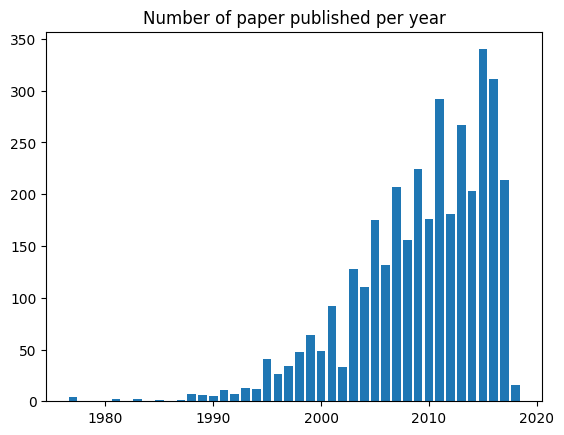

In [22]:
import matplotlib.pyplot as plt

data = db.papers.groupby('year').size()
plt.bar(data.index, data.values)
plt.title('Number of paper published per year')

In [23]:
ref = db.refs.groupby('idx_A')['idx_P'].count()
write = db.writes.groupby('idx_A')['idx_P'].count()
df_ref = pd.DataFrame(ref)


Text(0.5, 1.0, 'Distribution paper reference for an author')

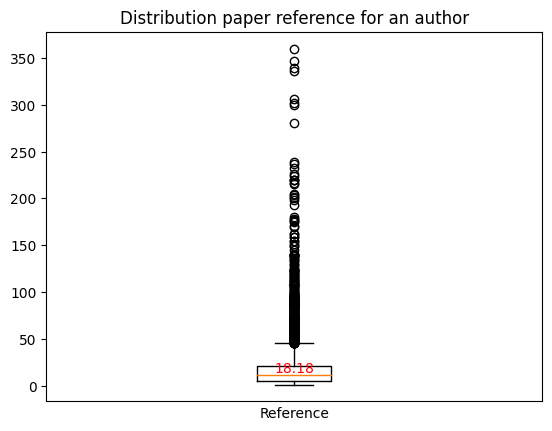

In [24]:
plt.boxplot(ref)
mean_val = ref.mean()
plt.text(1,mean_val,f'{mean_val:.2f}', ha='center', va='center', color='red')
plt.xticks([])
plt.xlabel('Reference')
plt.title('Distribution paper reference for an author')

Text(0.5, 1.0, 'Distribution paper publication for an author')

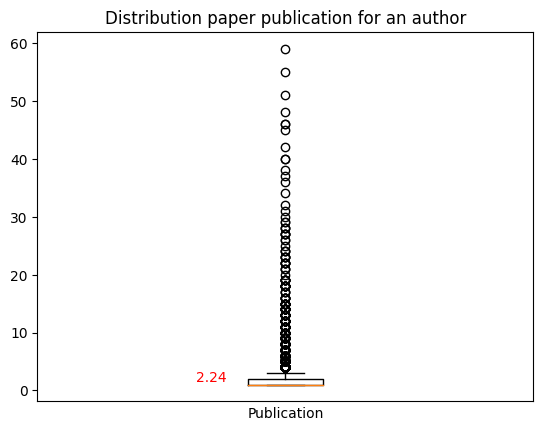

In [25]:
plt.boxplot(write)
mean_val = write.mean()
plt.text(0.85,mean_val,f'{mean_val:.2f}', ha='center', va='center', color='red')
plt.xticks([])
plt.xlabel('Publication')
plt.title('Distribution paper publication for an author')

In [26]:
fos = db.papers['fos'].explode().value_counts().head(10)
fos

fos
(Artificial intelligence, 0.0)    3428
(Training set, 0.0)                135
(Graph, 0.0)                        41
(Domain adaptation, 0.0)            34
(Labeled data, 0.0)                 30
(Reflectivity, 0.0)                 22
(Maximum likelihood, 0.0)           21
(Superresolution, 0.0)              15
(Saliency map, 0.0)                 13
(Object Class, 0.0)                 12
Name: count, dtype: int64

Text(0.5, 1.0, 'Top 10 popular field of study')

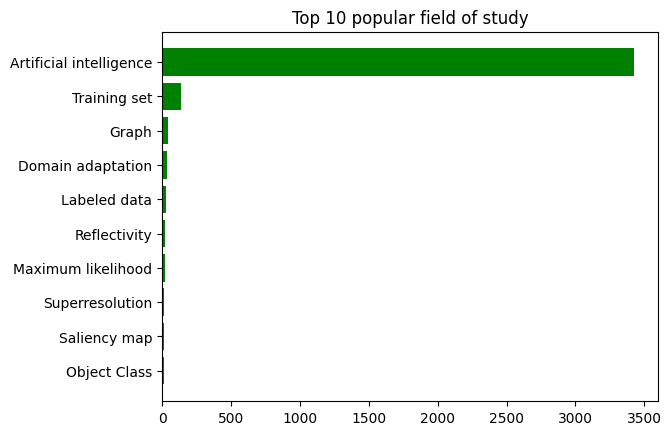

In [27]:
index = [index[0] for index in fos.index]
plt.barh(index[::-1], fos.values[::-1], color='green')
plt.title('Top 10 popular field of study')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


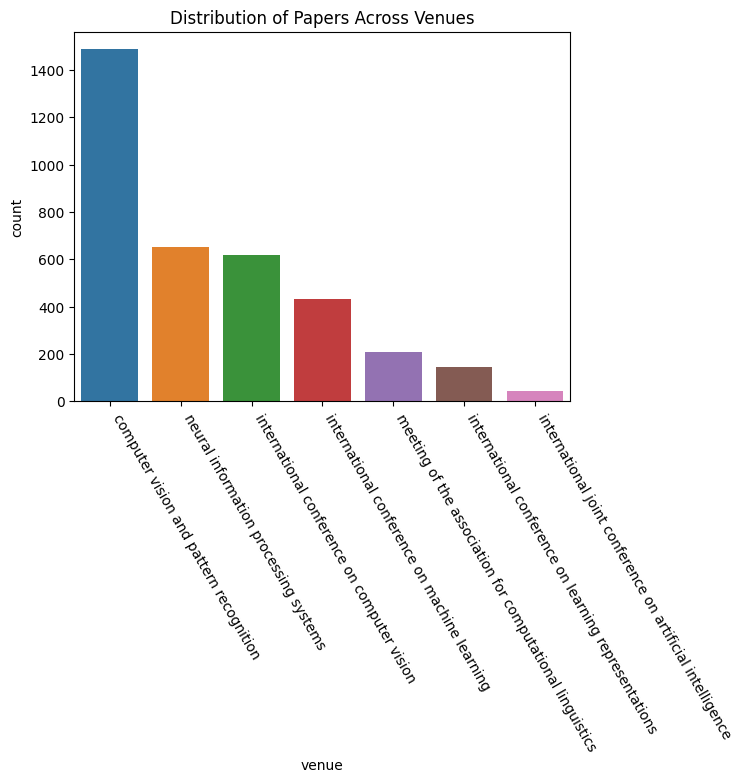

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=db.papers, x='venue', order=db.papers['venue'].value_counts().index)
plt.title("Distribution of Papers Across Venues")
plt.xticks(rotation=-60, ha='left')
plt.show()

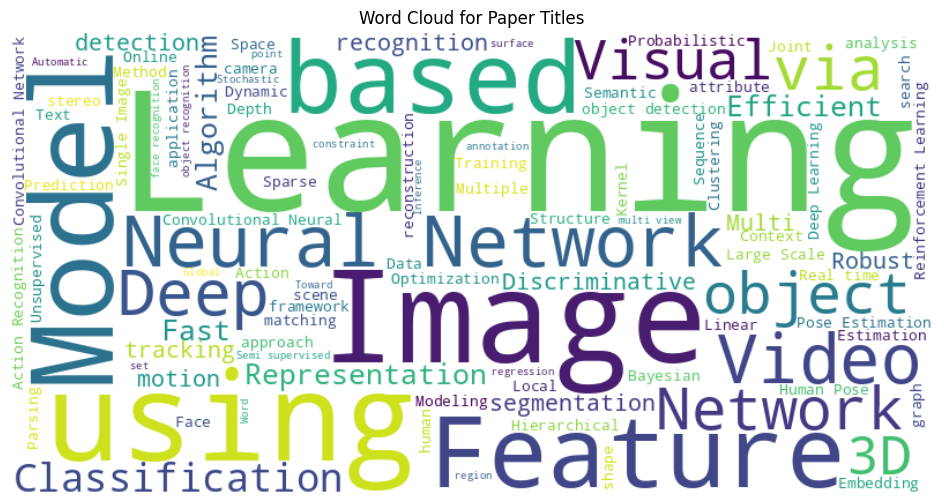

In [29]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(db.papers['title']))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Paper Titles')
plt.show()


## Data Preprocessing

In [30]:
df_interaction = db.links
df_interaction["inter_score"] = 1
df_interaction.head()

,idx_A,idx_P,rt,inter_score
gid,,,,
0,3590,0,True,1
1,3590,1448,True,1
2,3591,0,True,1
3,3591,26,True,1
4,3591,488,True,1


In [31]:
df_all = df_interaction.copy()
df_all[['idx_A', 'idx_P']] = df_all[['idx_A', 'idx_P']].astype(str)
df_all

,idx_A,idx_P,rt,inter_score
gid,,,,
0,3590,0,True,1
1,3590,1448,True,1
2,3591,0,True,1
3,3591,26,True,1
4,3591,488,True,1
...,...,...,...,...
106183,9062,933,False,1
106184,9062,979,False,1
106185,9062,988,False,1


In [32]:
# Metric
import numpy as np
import math

def getHitRatio(ranklist, gtItem):
    if gtItem in ranklist:
        return 1
    return 0

def get_rr(ranklist, gtItem):
    if gtItem in ranklist:
        rank = np.where(ranklist == gtItem)[0][0] + 1
        return 1/(rank)
    else:
        return 1/len(ranklist)
def getNDCG(ranklist, gtItem):
    ar = np.array(ranklist)
    if gtItem in ar:
        return math.log(2) / math.log(np.where(ar == gtItem)[0][0] + 2)
    return 0

In [33]:
# training testing split
# def train_test_split(df):
retrieve_name = df_all['idx_A'].value_counts()[df_all['idx_A'].value_counts() > 10].keys()
df_test = df_all[df_all['idx_A'].isin(retrieve_name)]
df_test = df_test.groupby('idx_A').tail(1)
df_train = df_all.drop(index=df_test.index)
df_train.shape, df_test.shape

((103286, 4), (2902, 4))

In [34]:
import random

random.seed(73)

def get_sampling(df_target, df_source, numbers_of_N_sample, generate_negative = False):
    '''
    1.
    return: test_rating in the shape of [ [user_pid,article] * N ]
    2.
    from the target dataframe, sampling the negative sample from source dataframe
    return: list in the shape of [ [((user_id, ground truth)) , [numbers_of_N_sample(negative samples)]] * N]
    '''
    test_rating = df_target[['idx_A','idx_P']].values.tolist()
    print('test_rating yield successfully!!!')
    
    if generate_negative:
        act_set = set(df_source["idx_P"].unique())
        mapping_user_act = df_source.groupby("idx_A")['idx_P'].apply(list)
        negative_test_rating = []
        for i in range(df_target.shape[0]):
            drop_id = test_rating[i][0]
            list_ = random.sample(list(act_set.difference(mapping_user_act[drop_id])), numbers_of_N_sample)
            negative_test_rating.append([test_rating[i], list_])
        print('negative_test_rating yield successfully!!!')

        return test_rating, negative_test_rating
    else:
        return test_rating

In [35]:
test_rating, negative_test_rating = get_sampling(df_test, df_train, 19, True)
# print(negative_test_rating)


test_rating yield successfully!!!
negative_test_rating yield successfully!!!


In [36]:
user_id_map = {i:v for i, v in enumerate(df_all["idx_A"].unique())}
inverse_user_id_map = {v:i for i, v in enumerate(df_all["idx_A"].unique())}
activity_id_map = {i:v for i, v in enumerate(df_all["idx_P"].unique())}
inverse_activity_id_map = {v:i for i, v in enumerate(df_all["idx_P"].unique())}
# print(user_id_map)
# print(inverse_activity_id_map)

In [37]:
df_train_map = df_train.copy()
df_test_map = df_test.copy()

df_train_map['idx_A'] = df_train_map['idx_A'].map(inverse_user_id_map)
df_train_map['idx_P'] = df_train_map['idx_P'].map(inverse_activity_id_map)
df_test_map['idx_A'] = df_test_map['idx_A'].map(inverse_user_id_map)
df_test_map['idx_P'] = df_test_map['idx_P'].map(inverse_activity_id_map)

### creating a mapping list for testing data   
test_rating_map = []
for i in range(len(test_rating)):
    test_rating_map.append([inverse_user_id_map[test_rating[i][0]],inverse_activity_id_map[test_rating[i][1]]])


### creating a mapping list for negative testing data
negative_test_rating_map = []
for i in range(len(negative_test_rating)):
    negative_test_rating_map.append([
                                     [inverse_user_id_map[negative_test_rating[i][0][0]],
                                      inverse_activity_id_map[negative_test_rating[i][0][1]]],
                                     list(map(lambda w: inverse_activity_id_map[w], negative_test_rating[i][1]))])

In [38]:
print('df_train_group_map shape: ',df_train_map.shape)
print('number of users: ', len(user_id_map))
print('number of items: ', len(activity_id_map))
print('The sparse matrix is one with shape (%d , %d), with %d non-zero read_times'
      %(len(user_id_map),len(activity_id_map), df_train_map.shape[0]))

df_train_group_map shape:  (103286, 4)
number of users:  5473
number of items:  3590
The sparse matrix is one with shape (5473 , 3590), with 103286 non-zero read_times


## Node2vec

In [39]:
!pip install networkx

In [40]:
import networkx as nx
from networkx.readwrite import json_graph
import pandas as pd
import json
import math 
import numpy as np
from os import listdir
from os.path import isfile, join

In [41]:
import json
with open("/kaggle/input/data-p2r/AI_collection.txt", "r") as file:
    lines = file.readlines()


In [42]:
data = [json.loads(line) for line in lines]
df = pd.DataFrame(data)[['id','title', 'authors','year','references']]
df

,id,title,authors,year,references
0,1483870316,"You Only Look Once: Unified, Real-Time Object ...","[{'name': 'Joseph Redmon', 'id': '2392241600'}...",2016,"[7746136, 48707324, 95258188, 124653583, 63970..."
1,1537698211,Human Pose Estimation with Iterative Error Fee...,"[{'name': 'Joao Carreira', 'id': '2429081565'}...",2016,"[144689751, 602397586, 1546771929, 1686810756,..."
2,1552576688,Minimum error bounded efficient ℓ1 tracker wit...,"[{'name': 'Xue Mei', 'id': '2308759442', 'org'...",2011,"[1524250066, 1538712971, 1995903777, 205318124..."
3,1569892065,Efficient Piecewise Training of Deep Structure...,"[{'name': 'Guosheng Lin', 'id': '2151505639', ...",2016,"[27675589, 54257720, 78159342, 125693051, 1032..."
4,1573040851,Jointly Modeling Embedding and Translation to ...,"[{'name': 'Yingwei Pan', 'id': '2117511774', '...",2016,"[877909479, 956551720, 1408639475, 1492731187,..."
...,...,...,...,...,...
3585,764651262,FlowNet: Learning Optical Flow with Convolutio...,"[{'name': 'Alexey Dosovitskiy', 'id': '1799886...",2015,"[51625820, 988642845, 1513100184, 1522301498, ..."
3586,845365781,Holistically-Nested Edge Detection,"[{'name': 'Saining Xie', 'id': '2551560347', '...",2015,"[109175241, 125693051, 790225446, 825165083, 1..."
3587,846669277,Differential Recurrent Neural Networks for Act...,"[{'name': 'Vivek Veeriah', 'id': '2653946760',...",2015,"[28988658, 1520854714, 1586730761, 1850742715,..."
3588,870084106,Predicting Deep Zero-Shot Convolutional Neural...,"[{'name': 'Jimmy Ba', 'id': '2097546270'}, {'n...",2015,"[21006490, 27961112, 93016980, 1514535095, 152..."


In [43]:
df_graph = df.fillna('0')
df_graph

,id,title,authors,year,references
0,1483870316,"You Only Look Once: Unified, Real-Time Object ...","[{'name': 'Joseph Redmon', 'id': '2392241600'}...",2016,"[7746136, 48707324, 95258188, 124653583, 63970..."
1,1537698211,Human Pose Estimation with Iterative Error Fee...,"[{'name': 'Joao Carreira', 'id': '2429081565'}...",2016,"[144689751, 602397586, 1546771929, 1686810756,..."
2,1552576688,Minimum error bounded efficient ℓ1 tracker wit...,"[{'name': 'Xue Mei', 'id': '2308759442', 'org'...",2011,"[1524250066, 1538712971, 1995903777, 205318124..."
3,1569892065,Efficient Piecewise Training of Deep Structure...,"[{'name': 'Guosheng Lin', 'id': '2151505639', ...",2016,"[27675589, 54257720, 78159342, 125693051, 1032..."
4,1573040851,Jointly Modeling Embedding and Translation to ...,"[{'name': 'Yingwei Pan', 'id': '2117511774', '...",2016,"[877909479, 956551720, 1408639475, 1492731187,..."
...,...,...,...,...,...
3585,764651262,FlowNet: Learning Optical Flow with Convolutio...,"[{'name': 'Alexey Dosovitskiy', 'id': '1799886...",2015,"[51625820, 988642845, 1513100184, 1522301498, ..."
3586,845365781,Holistically-Nested Edge Detection,"[{'name': 'Saining Xie', 'id': '2551560347', '...",2015,"[109175241, 125693051, 790225446, 825165083, 1..."
3587,846669277,Differential Recurrent Neural Networks for Act...,"[{'name': 'Vivek Veeriah', 'id': '2653946760',...",2015,"[28988658, 1520854714, 1586730761, 1850742715,..."
3588,870084106,Predicting Deep Zero-Shot Convolutional Neural...,"[{'name': 'Jimmy Ba', 'id': '2097546270'}, {'n...",2015,"[21006490, 27961112, 93016980, 1514535095, 152..."


In [44]:
# ref = db.paper_ref_paper

In [45]:
dict_nodes = {str(u): v for u,v in enumerate(db.paper_ref_paper) }

In [46]:
# dict_nodes = {v[0]:[int(x) for x in v[4]] for v in df_graph.values}
# len('1483870316')


In [47]:
# dict_nodes['0']

In [48]:
G = nx.from_dict_of_lists(dict_nodes)

In [49]:
print(G)

Graph with 6860 nodes and 30254 edges


In [50]:
!pip install node2vec
from node2vec import Node2Vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.


In [51]:
ccG = sorted(nx.connected_components(G), key = len, reverse=True)

In [52]:

i = 0
for c in ccG:
  i += 1
  if i==1:
    second_largest = G.subgraph(c)
    break

In [53]:
second_largest = G

In [54]:
print(second_largest)

Graph with 6860 nodes and 30254 edges


In [55]:
# nx.draw(second_largest)

In [ ]:
node2vec = Node2Vec(second_largest, dimensions=128, walk_length=100, num_walks=20)
model = node2vec.fit(window=20, min_count=1)

Computing transition probabilities:   0%|          | 0/6860 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [26:26<00:00, 15.87s/it]


In [ ]:
predictions = [int(item) for item, score in model.wv.most_similar(11)]
predictions

In [ ]:
from tqdm import tqdm

topK = 5
hits = []
ndcgs = []
rrs = []
for idx in tqdm(range(len(test_rating_map))):
    rating = test_rating_map[idx]
    items = negative_test_rating_map[idx][1]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    predictions = np.array([int(item) for item, score in model.wv.most_similar(gtItem)])
    ranklist = predictions
    rr = get_rr(predictions, gtItem)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    hits.append(hr)
    ndcgs.append(ndcg)
    rrs.append(rr)

In [ ]:
print(np.array(hits).mean())
print(np.array(rrs).mean())